<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Load-data" data-toc-modified-id="1-Load-data-1">1 Load data</a></span><ul class="toc-item"><li><span><a href="#1.1-First-look-at-data" data-toc-modified-id="1.1-First-look-at-data-1.1">1.1 First look at data</a></span></li><li><span><a href="#1.2-Assemble-loan-dataframe" data-toc-modified-id="1.2-Assemble-loan-dataframe-1.2">1.2 Assemble loan dataframe</a></span></li><li><span><a href="#1.3-Assemble-clients-info-dataframe" data-toc-modified-id="1.3-Assemble-clients-info-dataframe-1.3">1.3 Assemble clients info dataframe</a></span></li><li><span><a href="#1.4-Numeric-features" data-toc-modified-id="1.4-Numeric-features-1.4">1.4 Numeric features</a></span></li></ul></li><li><span><a href="#2-EDA" data-toc-modified-id="2-EDA-2">2 EDA</a></span><ul class="toc-item"><li><span><a href="#2.1-TARGET" data-toc-modified-id="2.1-TARGET-2.1">2.1 TARGET</a></span></li><li><span><a href="#2.2-Numeric-columns-values-distribution" data-toc-modified-id="2.2-Numeric-columns-values-distribution-2.2">2.2 Numeric columns values distribution</a></span></li><li><span><a href="#2.3-AGE-vs-TARGET" data-toc-modified-id="2.3-AGE-vs-TARGET-2.3">2.3 AGE vs TARGET</a></span></li><li><span><a href="#2.4-GENDER-vs-TARGET" data-toc-modified-id="2.4-GENDER-vs-TARGET-2.4">2.4 GENDER vs TARGET</a></span></li><li><span><a href="#2.5-EDUCATION-AND-PERSONAL-INCOME" data-toc-modified-id="2.5-EDUCATION-AND-PERSONAL-INCOME-2.5">2.5 EDUCATION AND PERSONAL INCOME</a></span></li><li><span><a href="#2.6-PERSONAL_INCOME-vs-TARGET" data-toc-modified-id="2.6-PERSONAL_INCOME-vs-TARGET-2.6">2.6 PERSONAL_INCOME vs TARGET</a></span></li><li><span><a href="#2.7-CHILD_TOTAL-vs-DEPENDANTS" data-toc-modified-id="2.7-CHILD_TOTAL-vs-DEPENDANTS-2.7">2.7 CHILD_TOTAL vs DEPENDANTS</a></span></li><li><span><a href="#2.8-Correlation-matrix" data-toc-modified-id="2.8-Correlation-matrix-2.8">2.8 Correlation matrix</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

%matplotlib inline
plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 15,
        'axes.labelsize': 15,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'font.size': 13,
        'figure.figsize': (8, 6),
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.3,
        'lines.markersize': 5.0,
        'xtick.minor.visible': True,
        'xtick.direction': 'in',
        'xtick.major.size': 20.0,
        'xtick.minor.size': 10.0,
        'xtick.top': False,
        'xtick.bottom': True,
        'ytick.minor.visible': True,
        'ytick.direction': 'in',
        'ytick.major.size': 12.0,
        'ytick.minor.size': 6.0,
        'ytick.right': True,
        'errorbar.capsize': 0.0,
    })

import warnings
warnings.filterwarnings('ignore')

In [2]:
!git branch

* main


In [3]:
# Разбиение данных на бины. В случае, когда таргет имеет значения 0 или 1 (бинарная классфиикация) 
# полезно для вычисления вероятности положительной метки (среднее в бине).
# Удобно применять к распределениями с тяжёлыми хвостами, когда количество данных в хвостах меньше
# и необходимо делать бины шире

def custom_binning(data, col, target, bin_edges):
    bin_centers = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    bin_values = [
        data[(data[col] > bin_edges[i])
             & (data[col] <= bin_edges[i + 1])].shape[0]
        for i in range(len(bin_edges) - 1)
    ]
    bin_values_pos = [
        data[(data[col] > bin_edges[i])
             & (data[col] <= bin_edges[i + 1])
             & (data[target] > 0)].shape[0]
        for i in range(len(bin_edges) - 1)
    ]

    return bin_centers, (np.array(bin_values_pos) / np.array(bin_values))

In [4]:
def plot_mean_bins(data, col, target, range_high, range_low, ax=None):
    points = data.loc[(data[col] < range_high) & (data[col] > range_low)]\
        .groupby(col).agg(MeanRevenue=(target, 'mean'))
    if ax == None:
        plt.plot(points, 'o-r')
        plt.xlabel(col)
        plt.ylabel(f'mean {target}')
        plt.show()
    else:
        ax.plot(points, 'o-r')
        ax.set_xlabel(col)
        ax.set_ylabel(f'mean {target}')

# 1 Load data

## 1.1 First look at data

Загружаем данные, смотрим, для всех ли клиентов (ID_CLIENT) содержится информация о них.

In [5]:
df_dict = {
    k.split('.')[0]: pd.read_csv('datasets/' + k)
    for k in os.listdir('datasets/')
}

In [6]:
for k, v in df_dict.items():
    print(f'{k}: {v.shape}')

D_work: (3, 3)
D_salary: (15523, 3)
D_loan: (21126, 2)
D_target: (15223, 3)
clients_info: (15223, 21)
D_pens: (2, 3)
D_clients: (16000, 14)
D_last_credit: (15223, 4)
D_job: (15223, 5)
D_close_loan: (21126, 2)


Не все клиенты (ID) представленные в 'D_target.csv' находятся в остальных наборах данных. 777 клиентов из 'D_clients.csv' не имеют соответсвующего значения целевой переменной. С остальными наборами всё в порядке.

In [10]:
clients_info = [k for k in df_dict.keys() if df_dict[k].shape[0] > 100 and k !='D_close_loan']

print("Number of IDs not presented in target dataframe")
print('-'*50)

for i in clients_info:
    if i != 'D_clients':
        print(f"{i}: {(~np.in1d(df_dict[i]['ID_CLIENT'].values, df_dict['D_target']['ID_CLIENT'].values)).sum()}")
        print(f"unique IDs    = {df_dict[i]['ID_CLIENT'].nunique()}")
    else:
        print(f"{i}: {(~np.in1d(df_dict[i]['ID'].values, df_dict['D_target']['ID_CLIENT'].values)).sum()}")
        print(f"unique IDs    = {df_dict[i]['ID'].nunique()}")
    print(f"total objects = {df_dict[i].shape[0]}")
    print('-'*50)

Number of IDs not presented in target dataframe
--------------------------------------------------
D_salary: 0
unique IDs    = 15223
total objects = 15523
--------------------------------------------------
D_loan: 0
unique IDs    = 15223
total objects = 21126
--------------------------------------------------
D_target: 0
unique IDs    = 15223
total objects = 15223
--------------------------------------------------
clients_info: 0
unique IDs    = 15223
total objects = 15223
--------------------------------------------------
D_clients: 777
unique IDs    = 16000
total objects = 16000
--------------------------------------------------
D_last_credit: 0
unique IDs    = 15223
total objects = 15223
--------------------------------------------------
D_job: 0
unique IDs    = 15223
total objects = 15223
--------------------------------------------------


## 1.2 Assemble loan dataframe

Сначала разберёмся со ссудами. Нужно добавить в данные о ссудах D_loan информацию о том, закрыты они или нет.
1. Проверяем, для всех ли ссуд есть информация об их закрытии
2. Делаем merge одного к другому. Делаю 'left', но в данном случае нет разницы, так как множества 'CLIENT_ID' совпадают.
3. Группируем по 'CLIENT_ID' и делаем соответствующие аггрегации для получения полного числа ссуд и числа закрытых ссуд. На этом этапе мы имеем dataframe с нужным числом столбцов, равных числу уникальных ID в остальных наборах данных и всей необходимой информацией.

In [11]:
# Есть ли ссуды, информация о закрытии которых отсутсвует

print(f"Missed loan IDs: {(~np.in1d(df_dict['D_close_loan']['ID_LOAN'].values, df_dict['D_loan']['ID_LOAN'].values)).sum()}")

Missed loan IDs: 0


In [12]:
# Соединяем

df_loan = df_dict['D_loan'].merge(df_dict['D_close_loan'], on='ID_LOAN', how='left').copy()
df_loan.head()

,ID_LOAN,ID_CLIENT,CLOSED_FL
0,1753790658,106804370,1
1,1753790659,106804371,1
2,1753790660,106804372,1
3,1753790661,106804372,0
4,1753790662,106804373,1


In [13]:
# Считаем число ссуд и число закрытых ссуд

df_loan = df_loan.groupby('ID_CLIENT',as_index=False)\
    .agg(LOAN_NUM_TOTAL=("CLOSED_FL", 'count'),
         LOAN_NUM_CLOSED=("CLOSED_FL", 'sum'))
df_loan.head()

,ID_CLIENT,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
0,106804370,1,1
1,106804371,1,1
2,106804372,2,1
3,106804373,1,1
4,106804374,2,1


## 1.3 Assemble clients info dataframe

Теперь собираем информацию о клиентах
1. Делаем merge необходимых данных (доход, ссуды) к прочей информации о клиенте
2. Проверяем наличие всех необходимых колонок
3. Проверяем данные на наличие противоречивой информации о клиенте, дублей и пропущенных значений
4. Преобразуем некоторые колонки

In [14]:
df_client = df_dict['D_clients'].copy().rename(columns={'ID': 'ID_CLIENT'})
df_client.head()

,ID_CLIENT,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,FL_PRESENCE_FL,OWN_AUTO
0,106805103,42,1,Среднее,Не состоял в браке,1,0,1,0,Московская область,Московская область,Московская область,1,0
1,106809308,28,1,Среднее специальное,Состою в браке,1,1,1,0,Читинская область,Читинская область,Читинская область,0,0
2,106805867,64,0,Среднее специальное,Состою в браке,2,0,1,1,Иркутская область,Иркутская область,Иркутская область,0,1
3,106808779,54,1,Среднее специальное,Состою в браке,0,0,1,0,Новосибирская область,Новосибирская область,Новосибирская область,1,1
4,106814289,26,0,Среднее специальное,Состою в браке,1,1,1,0,Красноярский край,Красноярский край,Красноярский край,1,0


In [15]:
# Добавляем целевую переменную и информацию о доходе к данным о клиенте

df_client = df_client.merge(df_dict['D_target'], on='ID_CLIENT', how='right')
df_client = df_client.merge(df_dict['D_salary'], on='ID_CLIENT', how='right')
df_client = df_client.merge(df_loan, on='ID_CLIENT', how='right')

In [17]:
# Все ли необходимые колонки есть в данных?

mandatory_clos = ['AGREEMENT_RK', 'TARGET', 'AGE', 'SOCSTATUS_WORK_FL', 
                 'SOCSTATUS_PENS_FL', 'GENDER', 'CHILD_TOTAL', 'DEPENDANTS',
                 'PERSONAL_INCOME', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED'] 

if all([col in df_client.columns for col in mandatory_clos]):
    print('All necessary columns are in dataframe')
else:
    print('Not all necessary columns are in dataframe')

All necessary columns are in dataframe


Проверяем, есть ли в данных дубликаты

In [18]:
print(f'Number of clients   = {df_client.shape[0]}')
print(f'Unique AGREEMENT_RK = {df_client.AGREEMENT_RK.nunique()}')
print(f'Unique ID_CLIENT    = {df_client.ID_CLIENT.nunique()}')
print("No duplicates =", df_client.AGREEMENT_RK.nunique() == df_client.shape[0])

Number of clients   = 15523
Unique AGREEMENT_RK = 15223
Unique ID_CLIENT    = 15223
No duplicates = False


Удаляем дубликаты, проверяем снова

In [19]:
df_client = df_client.drop_duplicates(ignore_index=True)
print(f'Number of clients   = {df_client.shape[0]}')
print(f'Unique AGREEMENT_RK = {df_client.AGREEMENT_RK.nunique()}')
print(f'Unique ID_CLIENT    = {df_client.ID_CLIENT.nunique()}')
print("No duplicates =", df_client.AGREEMENT_RK.nunique() == df_client.shape[0])

Number of clients   = 15223
Unique AGREEMENT_RK = 15223
Unique ID_CLIENT    = 15223
No duplicates = True


Проверяем, нет ли в данных пропусков

In [20]:
df_client.isnull().sum()

ID_CLIENT                  0
AGE                        0
GENDER                     0
EDUCATION                  0
MARITAL_STATUS             0
CHILD_TOTAL                0
DEPENDANTS                 0
SOCSTATUS_WORK_FL          0
SOCSTATUS_PENS_FL          0
REG_ADDRESS_PROVINCE       0
FACT_ADDRESS_PROVINCE      0
POSTAL_ADDRESS_PROVINCE    0
FL_PRESENCE_FL             0
OWN_AUTO                   0
AGREEMENT_RK               0
TARGET                     0
FAMILY_INCOME              0
PERSONAL_INCOME            0
LOAN_NUM_TOTAL             0
LOAN_NUM_CLOSED            0
dtype: int64

Проверяем данные на адекватность

In [21]:
print(f"AGE ({df_client.AGE.dtype}) \nmin = {df_client.AGE.min()}, max = {df_client.AGE.max()}\n" +
      "-" * 50)
print(
    f"GENDER ({df_client.GENDER.dtype}) \nunique values: {', '.join(df_client.GENDER.unique().astype(str).tolist())}\n"
    + "-" * 50)
print(
    f"EDUCATION ({df_client.EDUCATION.dtype}) \nunique values: {', '.join(df_client.EDUCATION.unique().astype(str).tolist())}\n"
    + "-" * 50)
print(
    f"MARITAL_STATUS ({df_client.MARITAL_STATUS.dtype}) \nunique values: {', '.join(df_client.MARITAL_STATUS.unique().astype(str).tolist())}\n"
    + "-" * 50)
print(
    f"CHILD_TOTAL ({df_client.CHILD_TOTAL.dtype}) \nmin = {df_client.CHILD_TOTAL.min()}, max = {df_client.CHILD_TOTAL.max()}\n"
    + "-" * 50)
print(
    f"DEPENDANTS ({df_client.DEPENDANTS.dtype}) \nmin = {df_client.DEPENDANTS.min()}, max = {df_client.DEPENDANTS.max()}\n"
    + "-" * 50)
print(
    f"SOCSTATUS_WORK_FL ({df_client.SOCSTATUS_WORK_FL.dtype}) \nunique values: {', '.join(df_client.SOCSTATUS_WORK_FL.unique().astype(str).tolist())}\n"
    + "-" * 50)
print(
    f"SOCSTATUS_PENS_FL ({df_client.SOCSTATUS_PENS_FL.dtype}) \nunique values: {', '.join(df_client.SOCSTATUS_PENS_FL.unique().astype(str).tolist())}\n"
    + "-" * 50)
print(
    f"OWN_AUTO ({df_client.OWN_AUTO.dtype}) \nunique values: {', '.join(df_client.OWN_AUTO.unique().astype(str).tolist())}\n"
    + "-" * 50)
print(
    f"TARGET ({df_client.TARGET.dtype}) \nunique values: {', '.join(df_client.TARGET.unique().astype(str).tolist())}\n"
    + "-" * 50)
print(
    f"PERSONAL_INCOME ({df_client.PERSONAL_INCOME.dtype}) \nmin = {df_client.PERSONAL_INCOME.min()}, max = {df_client.PERSONAL_INCOME.max()}\n"
    + "-" * 50)
print(
    f"FAMILY_INCOME ({df_client.FAMILY_INCOME.dtype}) \nmin = {df_client.FAMILY_INCOME.min()}, max = {df_client.FAMILY_INCOME.max()}\n"
    + "-" * 50)
print(
    f"LOAN_NUM_TOTAL ({df_client.LOAN_NUM_TOTAL.dtype}) \nmin = {df_client.LOAN_NUM_TOTAL.min()}, max = {df_client.LOAN_NUM_TOTAL.max()}\n"
    + "-" * 50)
print(
    f"LOAN_NUM_CLOSED ({df_client.LOAN_NUM_CLOSED.dtype}) \nmin = {df_client.LOAN_NUM_CLOSED.min()}, max = {df_client.LOAN_NUM_CLOSED.max()}\n"
    + "-" * 50)

AGE (int64) 
min = 21, max = 67
--------------------------------------------------
GENDER (int64) 
unique values: 1, 0
--------------------------------------------------
EDUCATION (object) 
unique values: Среднее специальное, Среднее, Неполное среднее, Высшее, Неоконченное высшее, Два и более высших образования, Ученая степень
--------------------------------------------------
MARITAL_STATUS (object) 
unique values: Состою в браке, Гражданский брак, Разведен(а), Не состоял в браке, Вдовец/Вдова
--------------------------------------------------
CHILD_TOTAL (int64) 
min = 0, max = 10
--------------------------------------------------
DEPENDANTS (int64) 
min = 0, max = 7
--------------------------------------------------
SOCSTATUS_WORK_FL (int64) 
unique values: 1, 0
--------------------------------------------------
SOCSTATUS_PENS_FL (int64) 
unique values: 0, 1
--------------------------------------------------
OWN_AUTO (int64) 
unique values: 0, 1, 2
----------------------------------

Проверим, на всякий случай, что закрытых кредитов не больше, чем открытых.

In [22]:
print(f"Clients with CLOSED LOANS > TOTAL LOANS: {(df_client.LOAN_NUM_CLOSED > df_client.LOAN_NUM_TOTAL).sum()}")

Clients with CLOSED LOANS > TOTAL LOANS: 0


В данных есть два категориальных предиктора, которые скорее порядковые: 'EDUCATION' и 'FAMILY_INCOME'. Закодируем их значения. Не уверен, что лучше, неоконченное высшее или среднее специальное, но кодировать их одним числом я не хочу.

In [23]:
education_dict = {'Неполное среднее': 1, 'Среднее': 2, 'Среднее специальное': 3,
                  'Неоконченное высшее': 4, 'Высшее': 5, 
                  'Два и более высших образования': 6, 'Ученая степень': 7}

family_income_dict = {'до 5000 руб.': 1, 'от 5000 до 10000 руб.': 2,
                      'от 10000 до 20000 руб.': 3, 'от 20000 до 50000 руб.': 4,
                      'свыше 50000 руб.': 5}

df_client.EDUCATION = df_client.EDUCATION.replace(education_dict)
df_client.FAMILY_INCOME = df_client.FAMILY_INCOME.replace(family_income_dict)

## 1.4 Numeric features

Числовые характеристики числовых столбцов. Видно, что они все имеют разный масштаб. Так как мы будем использовать линейную модель, вдальнейшем необходиму будет отмасштабирповать их, преминив StandaedScale или MinMaxScaler.

In [253]:
df_client.describe()

,ID_CLIENT,AGE,GENDER,EDUCATION,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,FL_PRESENCE_FL,OWN_AUTO,AGREEMENT_RK,TARGET,FAMILY_INCOME,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
count,1.522300e+04,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,1.522300e+04,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000
mean,1.068120e+08,40.406096,0.654536,3.098732,1.099389,0.645208,0.909610,0.134468,0.309794,0.116337,6.540183e+07,0.119030,3.356960,13853.836323,1.387769,0.751889
std,4.394646e+03,11.601068,0.475535,1.121645,0.995411,0.812252,0.286748,0.341165,0.462424,0.320844,4.568181e+06,0.323835,0.718685,9015.467617,0.793566,0.988499
min,1.068044e+08,21.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.991015e+07,0.000000,1.000000,24.000000,1.000000,0.000000
25%,1.068082e+08,30.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.192092e+07,0.000000,3.000000,8000.000000,1.000000,0.000000
50%,1.068120e+08,39.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.437100e+07,0.000000,3.000000,12000.000000,1.000000,0.000000
75%,1.068158e+08,50.000000,1.000000,3.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,6.708802e+07,0.000000,4.000000,17000.000000,2.000000,1.000000
max,1.068196e+08,67.000000,1.000000,7.000000,10.000000,7.000000,1.000000,1.000000,1.000000,2.000000,7.529224e+07,1.000000,5.000000,250000.000000,11.000000,11.000000


In [254]:
df_client.describe(include=object)

,MARITAL_STATUS,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE
count,15223,15223,15223,15223
unique,5,81,81,80
top,Состою в браке,Краснодарский край,Краснодарский край,Краснодарский край
freq,9416,674,674,674


Сохраним датафрейм вместе с остальными так, как мы будем делать это в eda.py, которое служит для подготовки данных.

In [321]:
df_client.to_csv('datasets/clients_info.csv', index=False)

# 2 EDA

Проведём небольшой разведочный анализ данных

## 2.1 TARGET

Классы не сбалансированы

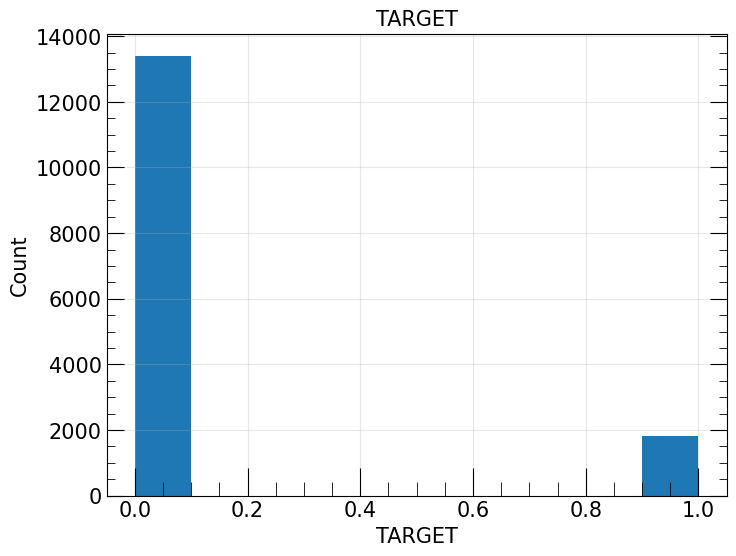

In [66]:
df_client.TARGET.hist()
plt.title('TARGET')
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.show()

## 2.2 Numeric columns values distribution

Построим сразу распределения для всех числовых предикторов. Где это возможно, укажем проценты нулевого и положительного класса (или только нулевого).

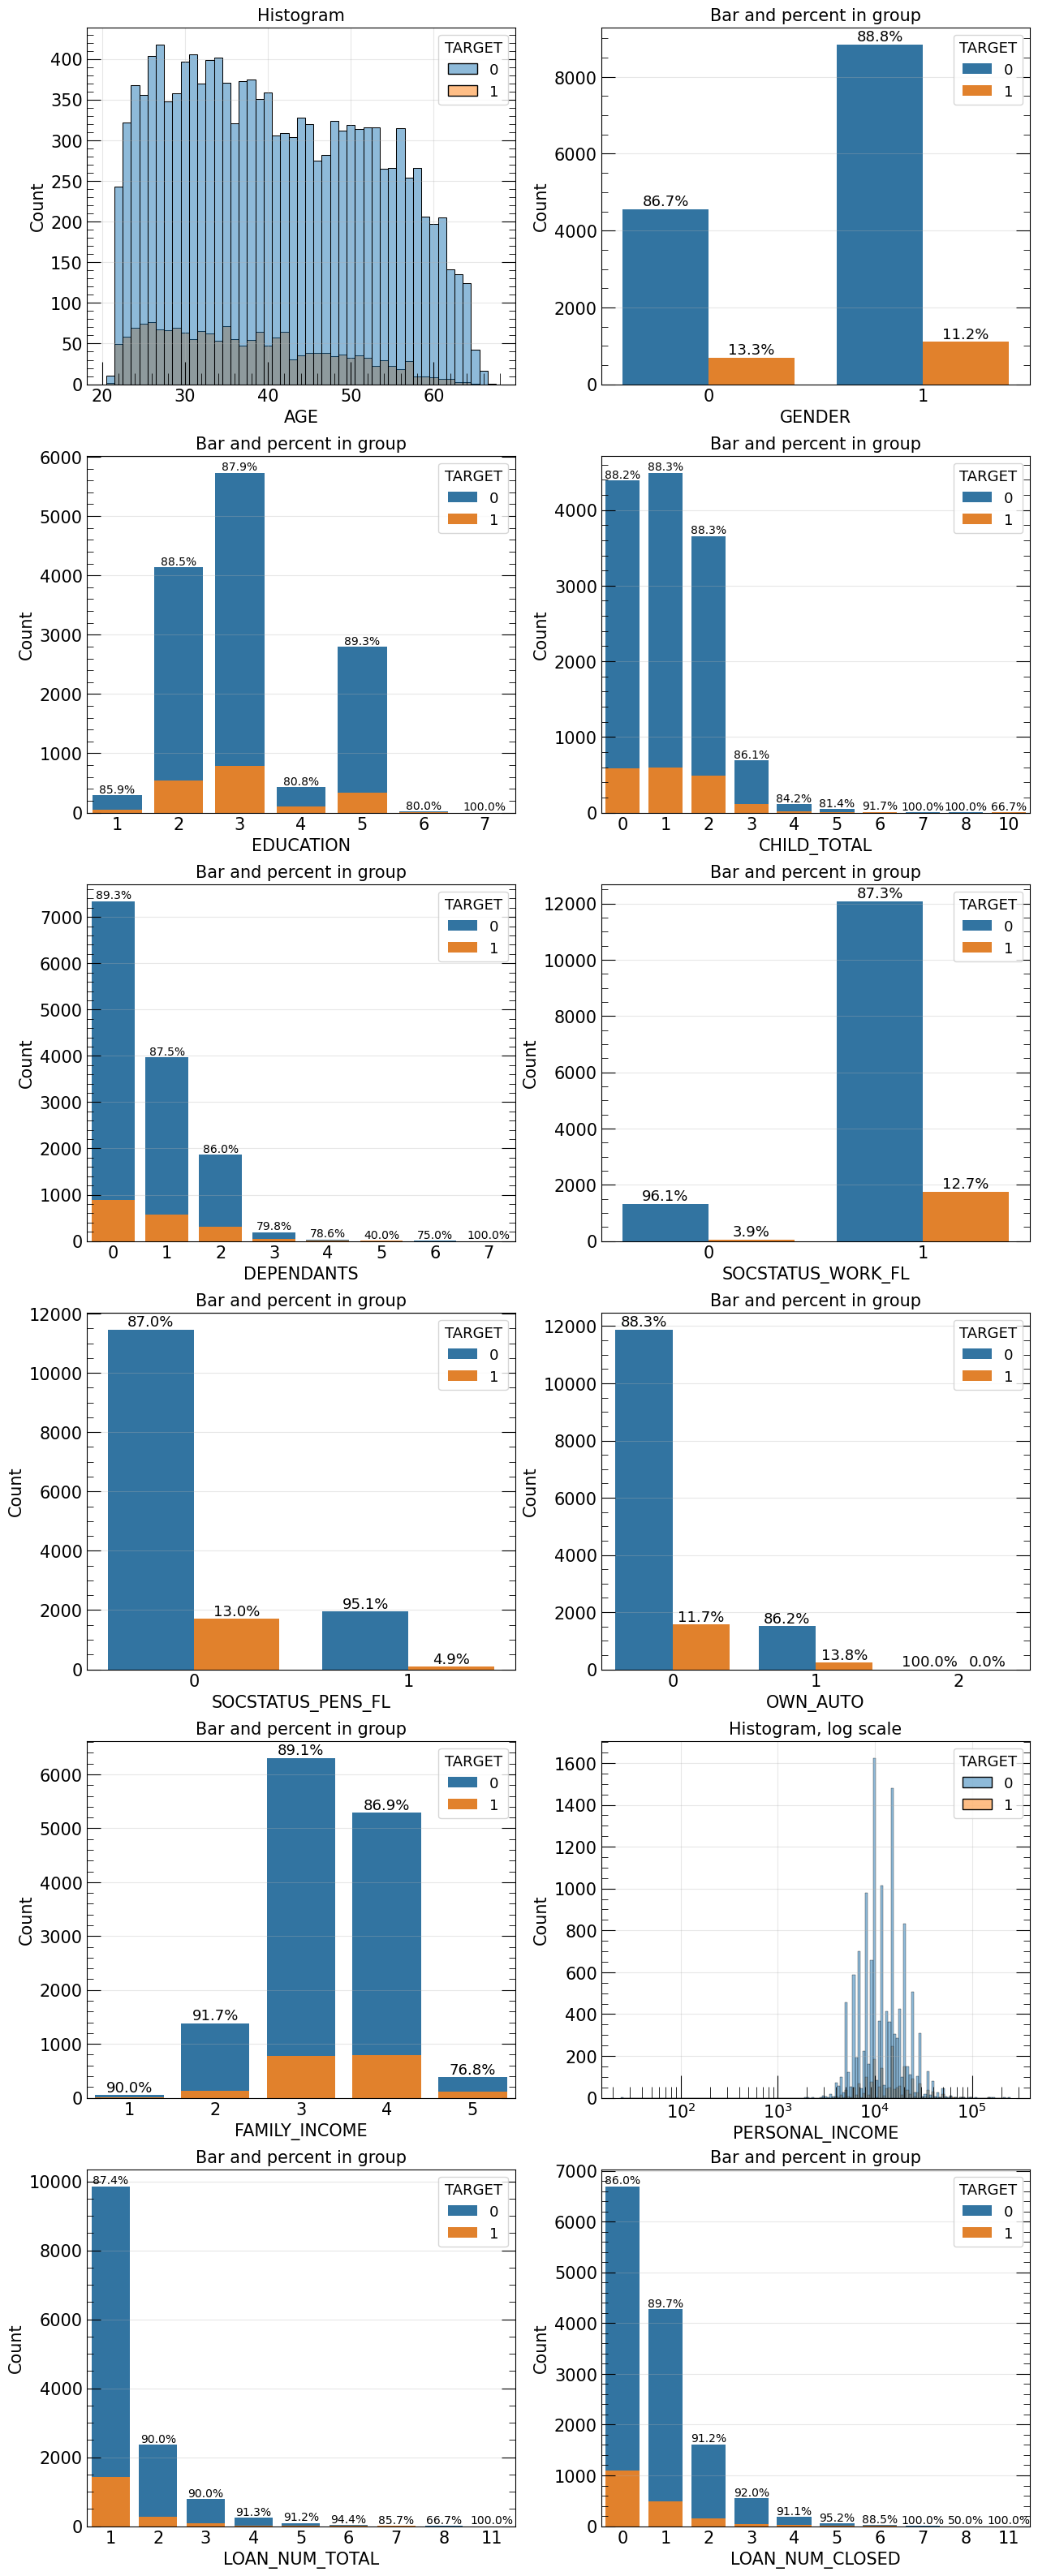

In [238]:
plt.figure(figsize=(15, 40))

numeric_cols = ['AGE', 'GENDER', 'EDUCATION', 'CHILD_TOTAL', 'DEPENDANTS',
               'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'OWN_AUTO',
               'FAMILY_INCOME', 'PERSONAL_INCOME', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED']

marital_status = ['MARITAL_STATUS']

for i_col, col in enumerate(numeric_cols):
    axis = plt.subplot(6, 2, i_col+1)
    
    # Где значений совсем мало, нарисуем проценты для обоих классов 
    if df_client[col].nunique() < 4:
        ax = sns.countplot(data=df_client,
                           x=col,
                           hue="TARGET",
                           ax=axis)
        axis.set(ylabel='Count', title='Bar and percent in group')
        axis.tick_params('x', length=0, width=0, which='both')
        for c, t in zip(axis.containers, [0, 1]):
            # custom label calculates percent and add an empty string so 0 value bars don't have a number
            test = df_client[df_client['TARGET'] == t].TARGET.count()
            labels = []
            for v, g in zip(c, sorted(df_client[col].unique())):
                denominator = df_client[df_client[col] == g].TARGET.count()
                numerator = v.get_height()
                labels.append(f'{numerator/denominator*100:0.1f}%')
            axis.bar_label(c, labels=labels, label_type='edge')
    
    # Где значений побольше, нарисуем процент класса 0 
    elif df_client[col].nunique() < 15:
        ax = sns.countplot(data=df_client,
                           x=col,
                           hue="TARGET",
                           dodge=False,
                           ax=axis)
        axis.tick_params('x', length=0, width=0, which='both')
        axis.set(ylabel='Count', title='Bar and percent in group')
        for c, t in zip(axis.containers, [0, 1]):
            labels = []
            for v, g in zip(c, sorted(df_client[col].unique())):
                denominator = df_client[df_client[col] == g].TARGET.count()
                numerator = v.get_height()
                if t == 0:
                    labels.append(f'{numerator/denominator*100:0.1f}%')
                else:
                    labels.append('')
            if col == 'FAMILY_INCOME':
                axis.bar_label(c, labels=labels, label_type='edge', size=13)
            else:
                axis.bar_label(c, labels=labels, label_type='edge', size=10)
    
    # Доход в логарифмическом масштабе
    elif col == 'PERSONAL_INCOME':
        axis.set(ylabel='Count', title='Histogram, log scale')
        sns.histplot(data=df_client,
                     x=col,
                     hue="TARGET",
                     multiple="layer",
                     log_scale=True,
                     ax=axis)
        
    # Остальное просто гистограммой
    else:
        axis.set(ylabel='Count', title='Histogram')
        sns.histplot(data=df_client,
                     x=col,
                     hue="TARGET",
                     multiple="layer",
                     ax=axis,
                     discrete=True)

## 2.3 AGE vs TARGET

Связана ли вероятность целевой перменной быть равной 1 с возрастом клиента? <br>
Похоже что да, вероятность падает с возрастом.<br>
P.S.: непараметрический критерий Манна-Уитни использовался тут потому, что распределение переменной AGE даже юлизко не напоминает нормальное. H0 - нулевая гипотеза о том, что для клиентов с целевой переменной 0 и 1 распределения AGE одинаковые.

In [330]:
def mann_whitney(data, column, target, alpha=0.001):
    print('Mann_Whitney test')
    x1 = data.loc[data[target] == 0, column]
    x2 = data.loc[data[target] != 0, column]
    stat, p_value = stats.mannwhitneyu(x1, x2)
    print(f'statistics = {stat}')
    print(f'p-value = {p_value}')
    if p_value < alpha:
        print('H0 rejected')
    else:
        print('H0 accepted')

Mann_Whitney test
statistics = 14336907.0
p-value = 1.2818314854797137e-35
H0 rejected


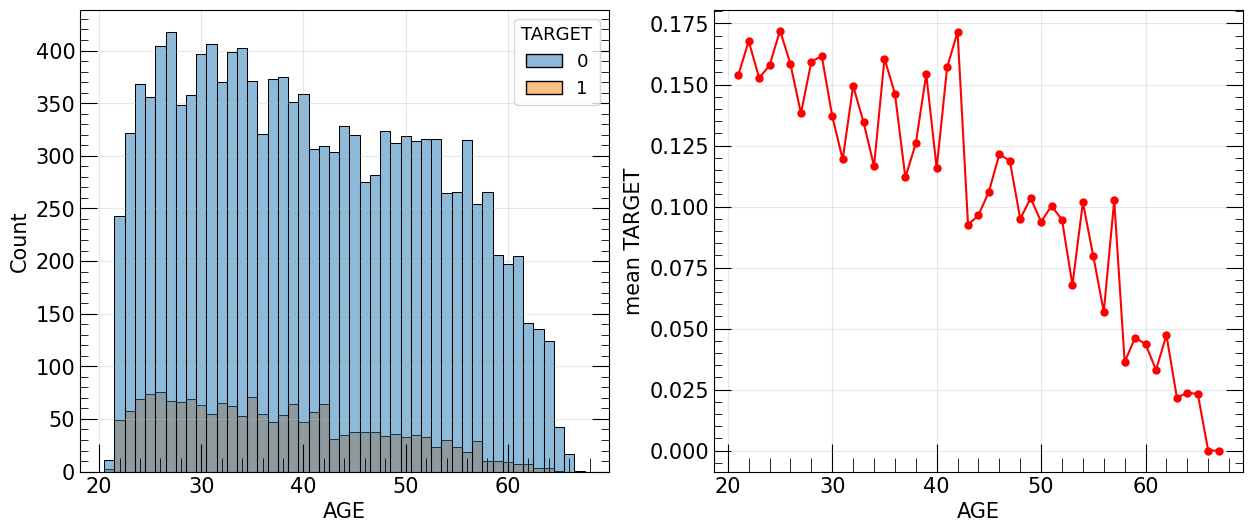

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

mann_whitney(df_client, 'AGE', 'TARGET')

sns.histplot(data=df_client,
             x='AGE',
             hue="TARGET",
             multiple="layer",
             ax=axs[0],
             discrete=True)

AGE_agg = df_client.groupby('AGE').agg(MeanTarget=('TARGET', 'mean'))
axs[1].plot(AGE_agg, 'o-r')
axs[1].set_xlabel('AGE')
axs[1].set_ylabel('mean TARGET')
plt.show()

## 2.4 GENDER vs TARGET

Связь целевой переменной с таргетом, также сделаем непараметрический тест Хи-квадрат, чтобы понять, есть ли статистически значимые различия в вероятности TARGET относительно категории GENDER. нулевая гипотеза - различий нет, она отброшена, так как p-value ниже заданного нами порога $\alpha$ = 0.001.

In [68]:
from tabulate import tabulate

def chi2_contingency_test(data, col1, col2, alpha=0.001):
    print('Chi2 contingency test')
    table = pd.crosstab(data[col2], data[col1])
    if data[col1].nunique() < 15:
        print(tabulate(table, headers='keys', tablefmt='psql'))
    table = table.to_numpy()
    res = stats.chi2_contingency(table)
    print(f'ndf = {res.dof}')
    print(f'statistics = {res.statistic}')
    print(f'p-value = {res.pvalue}')
    if res.pvalue < alpha:
        print('H0 rejected')
    else:
        print('H0 accepted')

In [70]:
# В столбцах пол, в строках таргет

chi2_contingency_test(df_client, 'GENDER', 'TARGET')

Chi2 contingency test
+----------+------+------+
|   TARGET |    0 |    1 |
|----------+------+------|
|        0 | 4561 | 8850 |
|        1 |  698 | 1114 |
+----------+------+------+
ndf = 1
statistics = 14.170591286007642
p-value = 0.00016695976077290065
H0 rejected


## 2.5 EDUCATION AND PERSONAL INCOME

Влияет ли уровень образования на доход клиента? <br>
Да, вдлияет! Средний доход растёт, если только клиент не имел неоосторожность защитить диссертацию. <br>
Также на превом графике (с полосками) числами показана вероятность целевой переменной быть равной 1 для каждой категории клиентов по образованию. Например, для единственного человека с учёной степенью эта вероятность равна 0, так как таргет для него 0.

In [232]:
df_education = df_client.groupby('EDUCATION')\
    .agg(mean_PERSONAL_INCOME=('PERSONAL_INCOME', 'mean'),
         mean_TARGET=('TARGET', 'mean'),
         count=('EDUCATION', 'count'))

df_education.index = education_dict.keys()

In [233]:
df_education

,mean_PERSONAL_INCOME,mean_TARGET,count
Неполное среднее,10226.229412,0.141176,340
Среднее,11979.645258,0.114768,4679
Среднее специальное,13369.489261,0.120589,6518
Неоконченное высшее,15595.374060,0.191729,532
Высшее,17685.286368,0.106926,3133
Два и более высших образования,25510.000000,0.200000,20
Ученая степень,10000.000000,0.000000,1


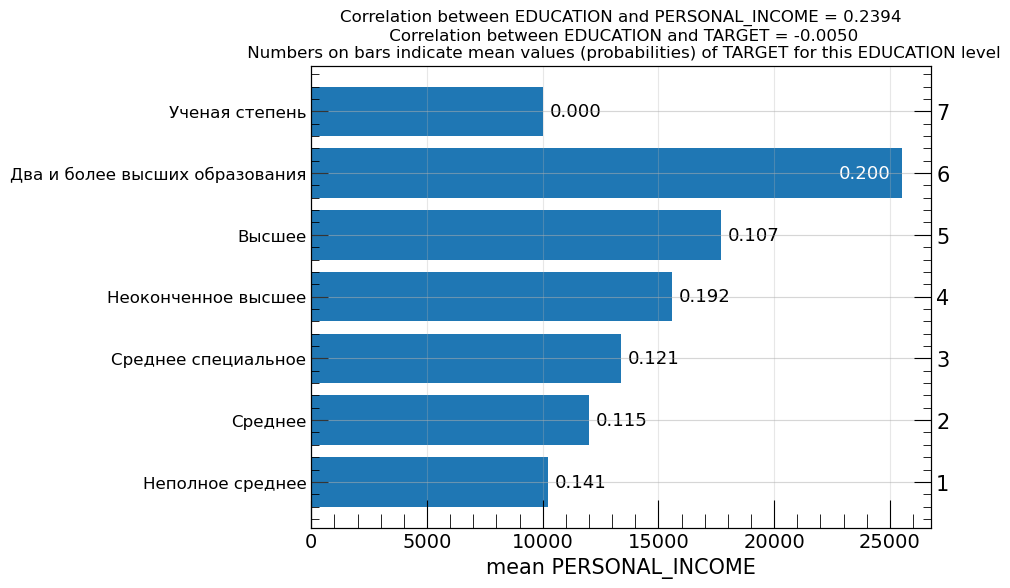

In [251]:
title = "Correlation between EDUCATION and PERSONAL_INCOME = %.4f" % np.corrcoef(df_client['EDUCATION'], df_client['PERSONAL_INCOME'])[0][1]\
    + "\n Correlation between EDUCATION and TARGET = %.4f" % np.corrcoef(df_client['EDUCATION'], df_client['TARGET'])[0][1]\
    + "\n Numbers on bars indicate mean values (probabilities) of TARGET for this EDUCATION level"

fig, ax1 = plt.subplots(figsize=(8, 6))
hbars = ax1.barh(y=df_education.index,
                 width=df_education['mean_PERSONAL_INCOME'])

ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=14)
ax1.set_xlabel('mean PERSONAL_INCOME')
right_target = ['%.3f' % t if t < 0.2 else '' for t in df_education['mean_TARGET']]
left_target = ['%.3f' % t if t >= 0.2 else '' for t in df_education['mean_TARGET']]
ax1.bar_label(hbars, left_target, padding=-45, color='white')
ax1.bar_label(hbars, right_target, padding=5, color='black')
ax1.set_title(title, fontsize=12)

ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(np.arange(df_education.shape[0]),
              labels=np.arange(df_education.shape[0])+1)

plt.show()

## 2.6 PERSONAL_INCOME vs TARGET

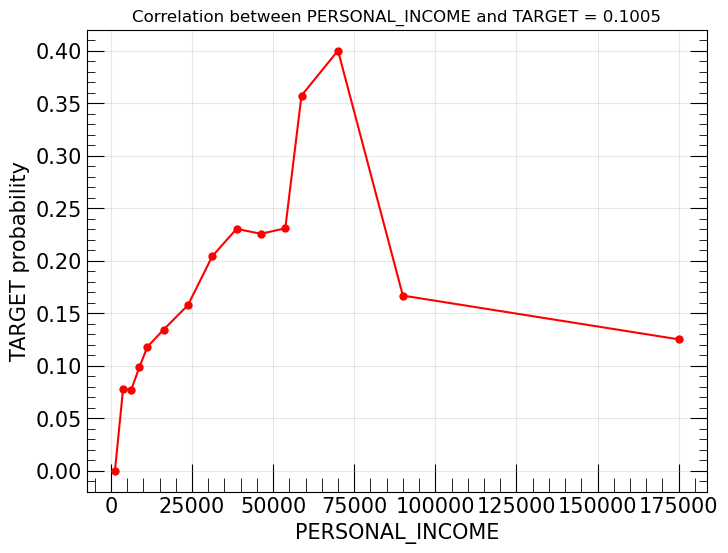

In [252]:
fig, ax = plt.subplots(figsize=(8, 6))

bin_edges = list(np.arange(0, 1.25e4, 2.5e3))\
    + list(np.arange(1.25e4, 6e4, 7.5e3)) + list(np.arange(6e4, 12e4, 2e4)) + [2.5e5]
bin_centers, bin_values = custom_binning(df_client, 'PERSONAL_INCOME', 'TARGET', bin_edges)

ax.plot(bin_centers, bin_values, 'r-o')
title = "Correlation between PERSONAL_INCOME and TARGET = %.4f" % df_client[['PERSONAL_INCOME', 'TARGET']].corr(method='spearman').iloc[0, 1]
ax.set_title(title, fontsize=12)
ax.set_xlabel('PERSONAL_INCOME')
ax.set_ylabel('TARGET probability')
plt.show()

## 2.7 CHILD_TOTAL vs DEPENDANTS

Прикольная табличка, которая показывает связь между числом CHILD_TOTAL и DEPENDANTS

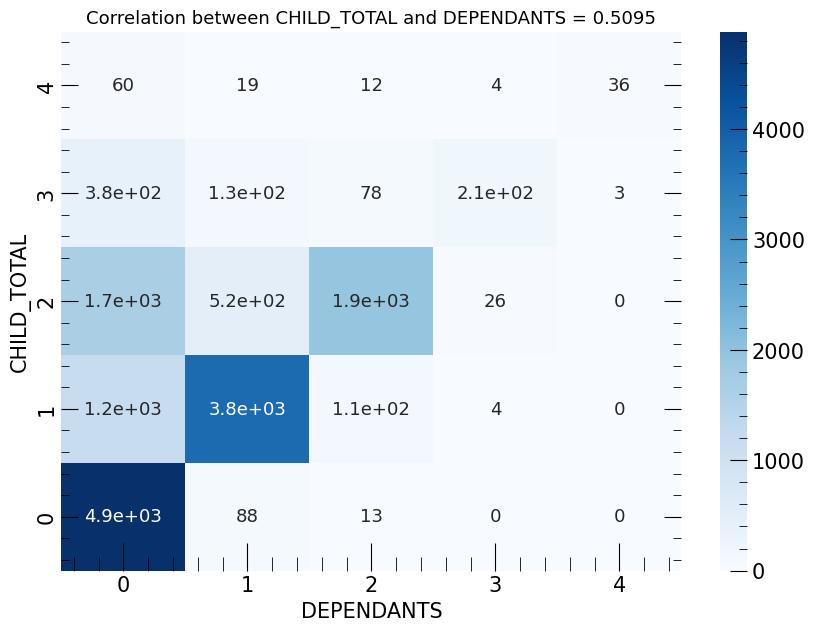

In [241]:
n_max = 5

plt.rcParams.update({'font.size':13})
plt.figure(figsize=(10, 7))

crosstab = pd.crosstab(df_client.CHILD_TOTAL, df_client.DEPENDANTS)
data = crosstab.values[:n_max, :n_max][::-1, :]
y = crosstab.index[:n_max][::-1]
x = crosstab.columns[:n_max]
df = pd.DataFrame(data, index=y, columns=x)

sns.heatmap(df, annot=True, cmap='Blues')
plt.gca().grid(False)
title = "Correlation between CHILD_TOTAL and DEPENDANTS = %.4f" % np.corrcoef(df_client['CHILD_TOTAL'], df_client['DEPENDANTS'])[0][1]
plt.title(title, size=13)

plt.show()

## 2.8 Correlation matrix

Строим матрицу корреляции, используем ранговую корреляцию Спирмена, так как ни одна из исследуемых переменных не распределена нормально и одна (доход клиента) имеет тяжёлый хвост вправо. В данном случае непарметрический критерий Спирмена подойдёт лучше.

Однако выискивать на матрице глазами наиболее скоррелированные признаки, не всегда удобно. Поэтому для пар с наиболее высокой корреляцией сделаем табличку.

Сразу нужно отметить, что все предикторы имеют корреляцию с целевой переменной 'TARGET' менее или примерно равную 0.1, то есть довольно небольшую. Ниже также приведен список коэффициентов корреляции целевой переменной со всеми остальными.

Наиболее значительная корреляция (> 0.25) наблюдается для переменных:
* SOCSTATUS_WORK_FL и SOCSTATUS_PENS_FL (-0.8), то есть люди на пенсии, скорее всего не работают
* LOAN_NUM_TOTAL и LOAN_NUM_CLOSED (0.73). Чем больше взятых ссуд, тем больше закрытых
* FAMILY_INCOME и PERSONAL_INCOME (0.66)

и так далее, см. таблицу ниже 

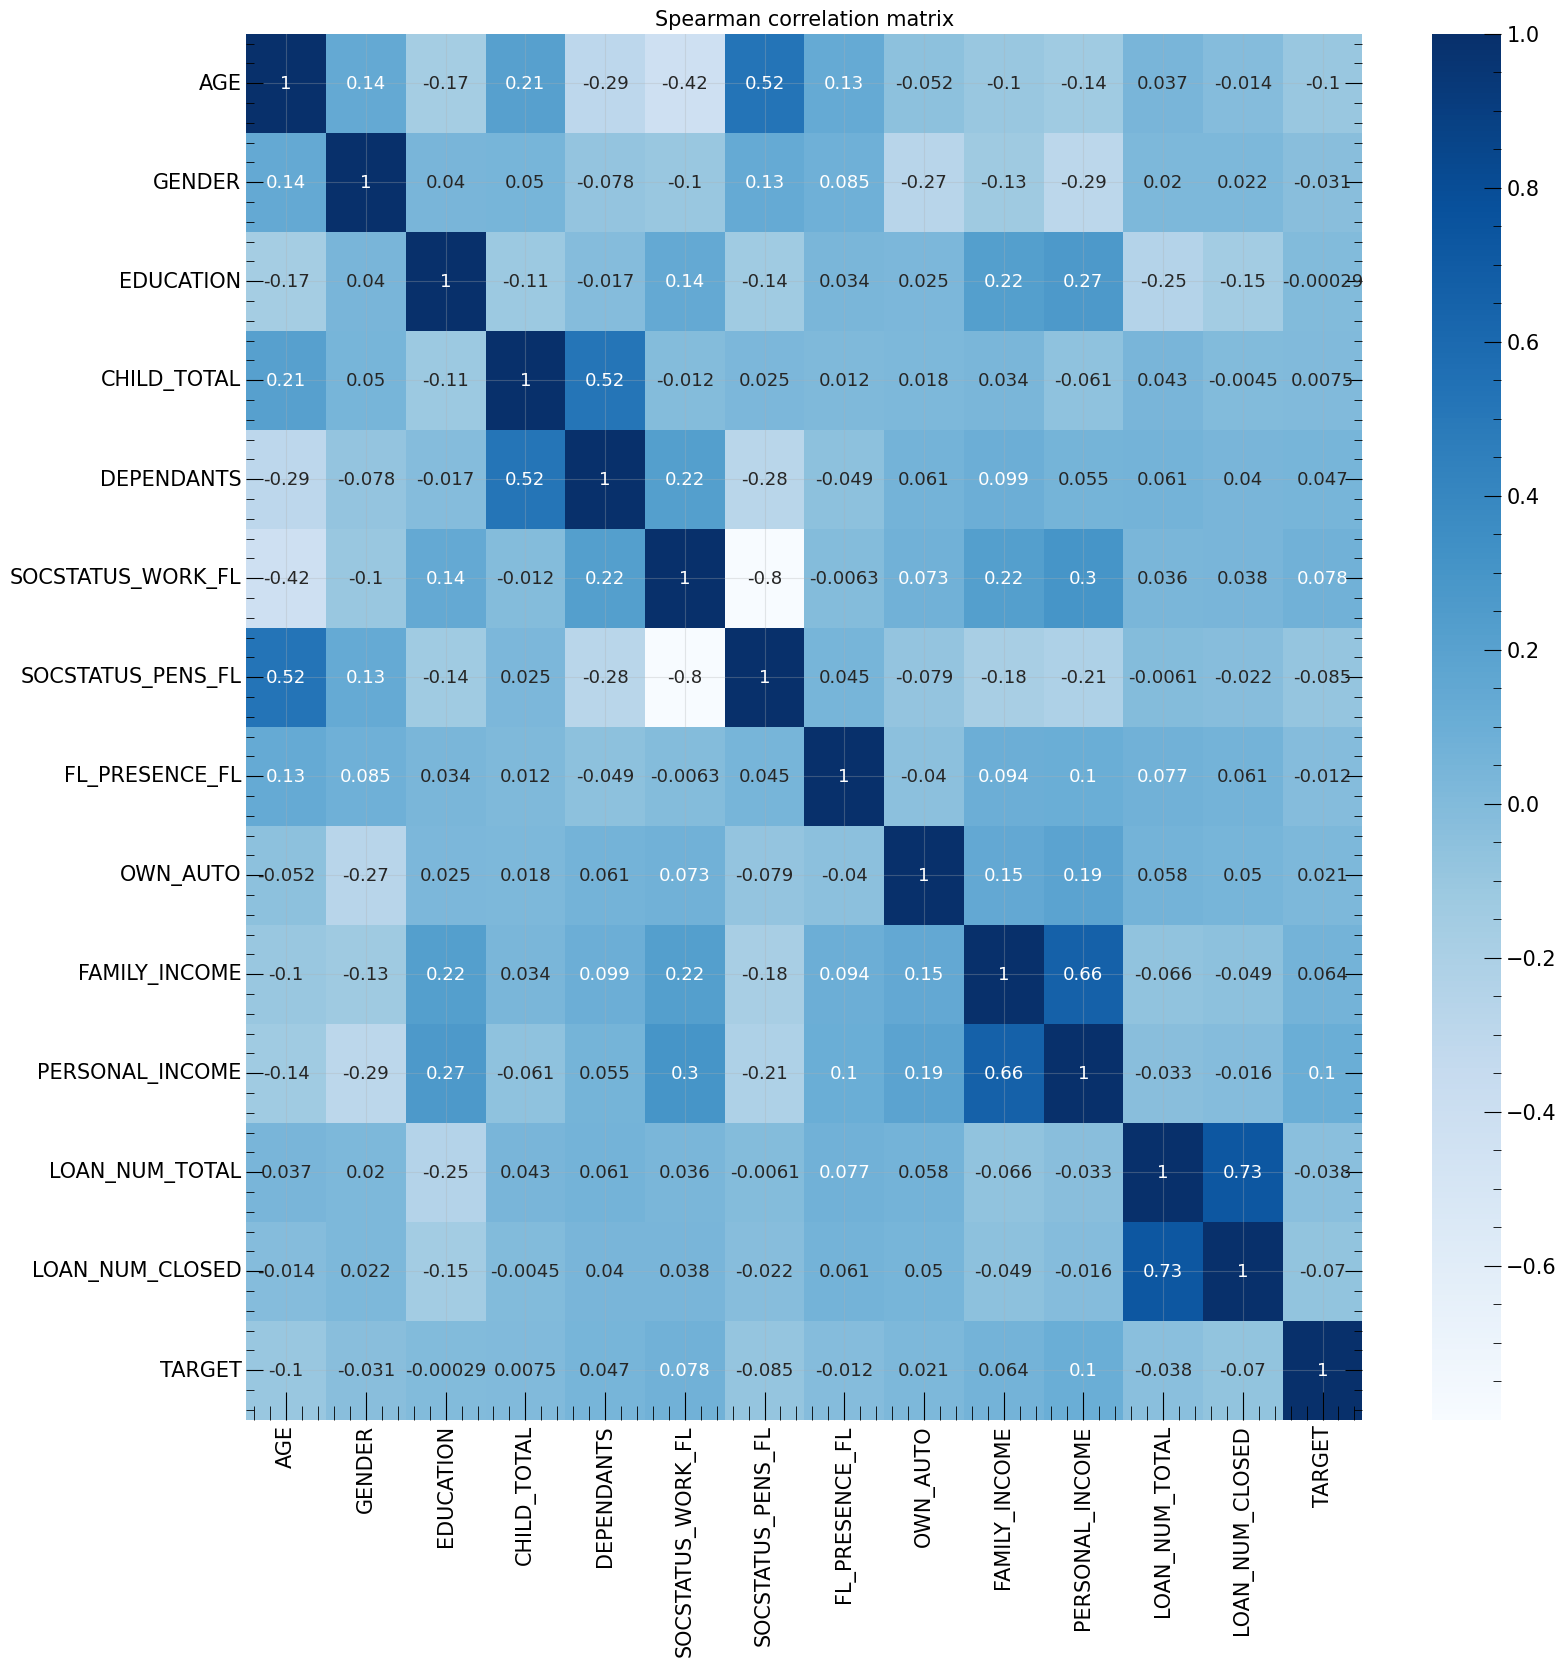

In [259]:
plt.figure(figsize=(18, 18))
df_client_copy = df_client.drop(['ID_CLIENT', 'AGREEMENT_RK', 'TARGET'], axis=1).copy()
df_client_copy['TARGET'] = df_client.TARGET
sns.heatmap(df_client_copy.corr(method='spearman'), annot=True, cmap='Blues')
plt.title('Spearman correlation matrix')
plt.show()

In [297]:
matrix = df_client_copy.corr(method='spearman')
indices = matrix.index
columns = matrix.columns

data_corr = []

for i, i_name in enumerate(indices):
    for j, j_name in enumerate(indices):
        if i_name == j_name or j < i:
            continue
        corr_coeff = matrix[i_name][j_name]
        if abs(corr_coeff) > 0.25:
            #print(f"Correlatrion between {i_name} and {j_name}\n{round(corr_coeff, 4)}")
            data_corr.append([f'{i_name} || {j_name}', corr_coeff])
            if i_name == 'TARGET' or j_name == 'TARGET':
                print(f"Correlatrion between {i_name} and {j_name}\n{round(corr_coeff, 4)}")
            
df_corr = pd.DataFrame(data=data_corr, columns=['Predictors pair', 'Correlation'])\
    .sort_values(by='Correlation', key=np.abs, ascending=False)\
    .reset_index(drop=True)

display(df_corr)

,Predictors pair,Correlation
0,SOCSTATUS_WORK_FL || SOCSTATUS_PENS_FL,-0.799768
1,LOAN_NUM_TOTAL || LOAN_NUM_CLOSED,0.728929
2,FAMILY_INCOME || PERSONAL_INCOME,0.660671
3,AGE || SOCSTATUS_PENS_FL,0.522795
4,CHILD_TOTAL || DEPENDANTS,0.518219
5,AGE || SOCSTATUS_WORK_FL,-0.420150
6,SOCSTATUS_WORK_FL || PERSONAL_INCOME,0.302420
7,AGE || DEPENDANTS,-0.294255
8,GENDER || PERSONAL_INCOME,-0.289067
9,DEPENDANTS || SOCSTATUS_PENS_FL,-0.276139


In [316]:
df_corr_target = pd.DataFrame(matrix['TARGET'])\
    .rename(columns={'TARGET': 'Correlation with TARGET'})\
    .sort_values(by='Correlation with TARGET', key=np.abs, ascending=False)\
    .drop(['TARGET'], axis=0)

display(df_corr_target)

,Correlation with TARGET
AGE,-0.100966
PERSONAL_INCOME,0.100548
SOCSTATUS_PENS_FL,-0.084826
SOCSTATUS_WORK_FL,0.078377
LOAN_NUM_CLOSED,-0.069849
FAMILY_INCOME,0.063926
DEPENDANTS,0.046616
LOAN_NUM_TOTAL,-0.037813
GENDER,-0.030723
OWN_AUTO,0.021074
